In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('sellers.csv','sellers'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='rajSQL09',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/gitanshraj/Downloads/datas for practice/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_descrip

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="rajSQL09",
                            database="ecommerce")

cur=db.cursor()
                            

# List all unique cities where customers are located.

In [3]:
query= """select distinct customer_city from customers"""

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data)
df.head(15)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [4]:
query= """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""

cur.execute(query)

data= cur.fetchall()

"total orders place in 2017 are", data[0][0]

('total orders place in 2017 are', 225505)

# Find the total sales per category.

In [5]:
query= """select products.product_category category, round(sum(payments.payment_value),2) sales
from products join order_items on products.product_id = order_items.product_id
join payments on order_items.order_id = payments.order_id
group by category"""

cur.execute(query) 

data= cur.fetchall()

#data or

df=pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,perfumery,3.243127e+07
1,Furniture Decoration,9.153129e+07
2,telephony,3.116045e+07
3,bed table bath,1.096034e+08
4,automotive,5.454684e+07
...,...,...
69,cds music dvds,7.676352e+04
70,La Cuisine,1.864659e+05
71,Fashion Children's Clothing,5.028288e+04
72,PC Gamer,1.391635e+05


# Calculate the percentage of orders that were paid in installments.

In [6]:
query= """ select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data= cur.fetchall()

"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('100.0000'))

# Count the number of customers from each state.

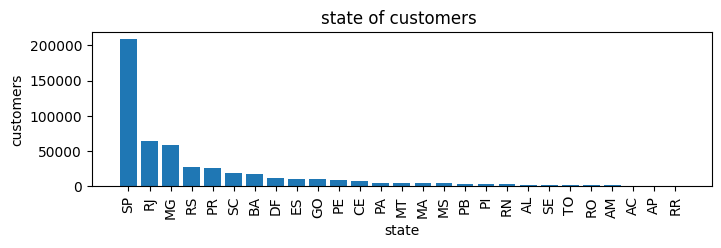

In [7]:
query= """ select customer_state state,count(customer_id) customers from customers group by state """

cur.execute(query)

data= cur.fetchall()

#data

df= pd.DataFrame(data,columns=["state","customers"])
df= df.sort_values(by="customers", ascending= False)

plt.figure(figsize=(8,2))
plt.bar(df["state"],df["customers"])
plt.xticks(rotation=90)
plt.xlabel("state")
plt.ylabel("customers")
plt.title("state of customers ")
plt.show()

# Calculate the number of orders per month in 2018

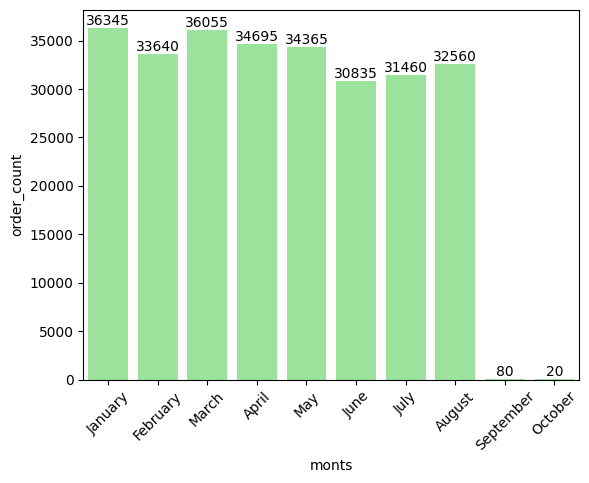

In [8]:
query= """ select monthname(order_purchase_timestamp) months,count(order_id) order_count from orders 
where year(order_purchase_timestamp)=2018 
group by months """

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data,columns=["monts","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x=df["monts"],y=df["order_count"],data=df,order=o, color="lightgreen")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
query= """ with count_per_order as
(select orders.order_id, orders.customer_id, round(count(order_items.order_id),2) as OC from orders 
join order_items on orders.order_id=order_items.order_id group by orders.order_id, orders.customer_id)

select customers.customer_city,round(avg(count_per_order.OC),2) from customers 
join count_per_order on customers.customer_id=count_per_order.customer_id
group by customers.customer_city"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data,columns=["customer city","average orders"])
df

,customer city,average orders
0,treze tilias,25.45
1,indaial,22.31
2,sao jose dos campos,22.77
3,sao paulo,23.12
4,porto alegre,23.50
...,...,...
4105,guairaca,40.00
4106,sambaiba,20.00
4107,japaratuba,20.00
4108,tuiuti,20.00


# Calculate the percentage of total revenue contributed by each product category.

In [10]:

query= """ select products.product_category category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items on products.product_id = order_items.product_id
join payments on order_items.order_id = payments.order_id
group by category order by sales desc"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data,columns= ["category","sales percent"])
df

,category,sales percent
0,bed table bath,171.16
1,HEALTH BEAUTY,165.65
2,computer accessories,158.45
3,Furniture Decoration,142.94
4,Watches present,142.84
...,...,...
69,PC Gamer,0.22
70,House Comfort 2,0.17
71,cds music dvds,0.12
72,Fashion Children's Clothing,0.08


# Identify the correlation between product price and the number of times a product has been purchased.

In [11]:

query= """ select products.product_category category, count(order_items.product_id),round(avg(order_items.price),2) from products 
join order_items on products.product_id=order_items.product_id group by category """

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data,columns=["category","order_count","avg_price"])

arr1=df["order_count"]
arr2=df["avg_price"]

a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased-->",a[1][0])

The correlation between product price and the number of times a product has been purchased--> -0.10631514167157569


# Calculate the total revenue generated by each seller, and rank them by revenue.

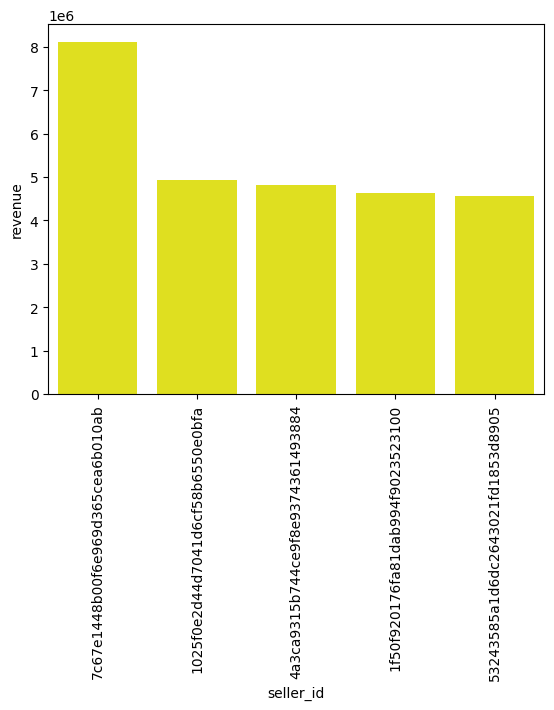

In [12]:

query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df, color="yellow")
plt.xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history.

In [13]:
query= """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns=["customer_id","time","payment","avg mov"])
df

,customer_id,time,payment,avg mov
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2077715,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077716,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077717,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2077718,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year


In [14]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["year","months","payments","cumulative_vlu"])
df

,year,months,payments,cumulative_vlu
0,2016,9,5044.80,5.044800e+03
1,2016,10,1181809.60,1.186854e+06
2,2016,12,392.40,1.187247e+06
3,2017,1,2769760.80,3.957008e+06
4,2017,2,5838160.19,9.795168e+06
5,2017,3,8997271.99,1.879244e+07
6,2017,4,8355760.59,2.714820e+07
7,2017,5,11858376.40,3.900658e+07
8,2017,6,10225527.61,4.923210e+07
9,2017,7,11847658.39,6.107976e+07


# Calculate the year-over-year growth rate of total sales.

In [15]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

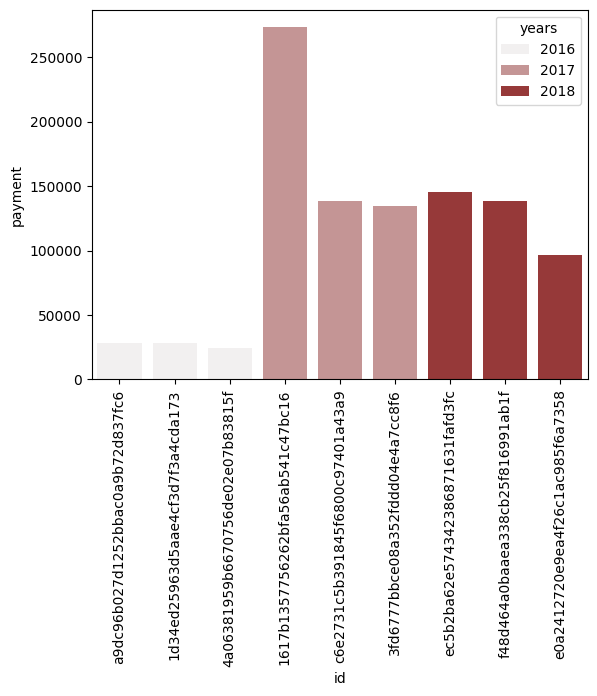

In [16]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years", palette="light:brown")
plt.xticks(rotation = 90)
plt.show()


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]